In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt, animation
import numpy as np
import itertools
import pandas as pd

In [2]:
def generate_random_city_graph(connection_prob=0.1, min_weight=1, max_weight=100):
    """
    Generate a random graph representing cities connected with weighted edges.

    Parameters:
    - num_cities (int): Number of cities (nodes) in the graph.
    - connection_prob (float): Probability of a connection (edge) between any two cities.
    - min_weight (int): Minimum weight (distance) for the edges.
    - max_weight (int): Maximum weight (distance) for the edges.

    Returns:
    - G (networkx.Graph): A NetworkX graph with cities as nodes and weighted edges.
    """
    num_cities = random.randint(5,10) # Generate just from 20 to 26 because I want only alphabet characters as nodes
    # Generate random city names (A, B, C, ...)
    city_names = [chr(65 + i) for i in range(num_cities)]

    # Create a graph
    G = nx.Graph()

    # Add cities as nodes
    G.add_nodes_from(city_names)

    # Randomly connect cities with random weights (distances)
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            weight = random.randint(min_weight, max_weight)  # Random distance
            G.add_edge(city_names[i], city_names[j], weight=weight)

    return G

In [3]:
# Example usage
random_graph = generate_random_city_graph()

In [4]:
def draw_graph(G):
    """
    Draw the generated graph with cities and weighted connections.

    Parameters:
    - G (networkx.Graph): The graph to be drawn.
    """
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)

    # Clear any previous plot
    plt.clf()
    
    # Draw the graph
    nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=5, font_weight='bold')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in edges})
    #nx.draw_networkx_edge(G, pos, with_labels=False)

    plt.title("Graph")
    plt.show()
    return pos

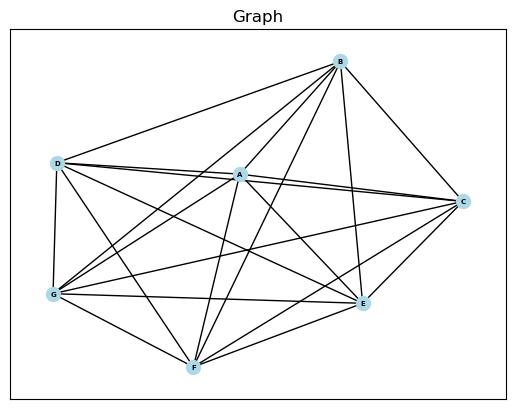

In [5]:
originalLayout = draw_graph(random_graph)

In [6]:
nx.adjacency_matrix(random_graph)

<7x7 sparse array of type '<class 'numpy.int32'>'
	with 42 stored elements in Compressed Sparse Row format>